In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import graph_tool.all as gt

In [10]:
from graph_world.beam.generator_config_sampler import ParamSamplerSpec
from graph_world.substructure.beam_handler import SampleSubstructureDatasetDoFn, ConvertToTorchGeoDataParDo
from graph_world.substructure.simulator import Substructure

In [11]:
# Get graph data
substruct = Substructure.TAILED_TRIANGLE_GRAPH
param_sampler_specs = [
    ParamSamplerSpec(name="num_graphs",
                     min_val=1000,
                     max_val=1000),
    ParamSamplerSpec(name="num_vertices",
                     min_val=10,
                     max_val=10),
    ParamSamplerSpec(name="edge_prob",
                     min_val=0.6,
                     max_val=0.6),
    ParamSamplerSpec(name="train_prob",
                     min_val=0.6,
                     max_val=0.6)
]
sampler_dofn = SampleSubstructureDatasetDoFn(param_sampler_specs, substruct)
sampler_out = next(sampler_dofn.process(sample_id=0))

In [12]:
# Convert to torchgeo data
convert_dofn = ConvertToTorchGeoDataParDo(output_path="/tmp", batch_size=64)
convert_out = next(convert_dofn.process(sampler_out))

In [13]:
# Compute graph metrics
from graph_world.substructure.beam_handler import ComputeSubstructureGraphMetricsParDo
metrics_dofn = ComputeSubstructureGraphMetricsParDo()
metrics_out = next(metrics_dofn.process(convert_out))

In [14]:
# Try GCN training with graph-world library fns
import gin

from graph_world.models.benchmarker import Benchmarker, BenchmarkGNNParDo
from graph_world.models.wrappers import GraphGCN

gin.bind_parameter('GraphGCN.num_features', 1)
gin.bind_parameter('GraphGCN.hidden_channels', 16)
gin.bind_parameter('GraphGCN.epochs', 100)
gin.bind_parameter('GraphGCN.lr', 0.0001)
gin.bind_parameter('GraphGCN.model_name', 'GCNGraphBenchmarker')

benchmarker_wrappers = [
    GraphGCN,
]
benchmarker_dofn = BenchmarkGNNParDo(benchmarker_wrappers)
benchmarker_dofn.SetOutputPath('/tmp')

In [15]:
benchmarker_out = next(benchmarker_dofn.process(metrics_out))

In [ ]:
# Copy GCN model from https://colab.sandbox.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=HvhgQoO8Svw4
import torch
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_node_features):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(16, 1)
print(model)

In [ ]:
# Copy GCN training from https://colab.sandbox.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing#scrollTo=HvhgQoO8Svw4
model = GCN(hidden_channels=16, num_node_features=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.MSELoss()

train_loader = convert_out['torch_dataset']['train']
test_loader = convert_out['torch_dataset']['test']

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

def test_mse(loader):
     model.eval()

     total_sse = 0.0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         mse = float(criterion(out[:, 0], data.y))
         total_sse += mse * data.batch.size().numel()
     return total_sse / len(loader.dataset)


for epoch in range(1, 171):
    train()
    train_acc = test(train_loader)
    test_acc = test_mse(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

# Check that the labels make sense

In [32]:
#@title Utils for graph processing / motif counting
import graph_tool as gt
import networkx as nx

# Motif utils
def get_star_graph():
  g = gt.Graph(directed=False)
  g.add_edge(0, 1)
  g.add_edge(0, 2)
  g.add_edge(0, 3)
  return g

def get_triangle_graph():
  g = gt.Graph(directed=False)
  g.add_edge(0, 1)
  g.add_edge(1, 2)
  g.add_edge(2, 0)
  return g

def get_tailed_triangle_graph():
  g = get_triangle_graph()
  g.add_edge(0, 3)
  return g

def get_chordal_cycle_graph():
  g = get_tailed_triangle_graph()
  g.add_edge(1, 3)
  return g

STAR_GRAPH = get_star_graph()
TAILED_TRIANGLE_GRAPH = get_tailed_triangle_graph()
CHORDAL_CYCLE_GRAPH = get_chordal_cycle_graph()

# Conversion utils
def get_dgl_edges(dgl_graph):
  edgeset = set([tuple(sorted((int(x), int(y)))) for
                 x, y in zip(*dgl_graph.edges())])
  return list(edgeset)

def dgl_to_gt(dgl_graph):
  g = gt.Graph(directed=False)
  g.add_edge_list(get_dgl_edges(dgl_graph))
  return g

def dgl_to_nx(dgl_graph):
  g = nx.Graph()
  g.add_edges_from(get_dgl_edges(dgl_graph))
  return g

def gt_to_nx(gt_graph):
  nx_graph = nx.Graph()
  edge_list = [(int(e.source()), int(e.target())) for e in gt_graph.edges()]
  nx_graph.add_edges_from(edge_list)
  return nx_graph

def plot_graph(test_index):
  print("this graph has %d of %s" % (
      sampler_out['data']['substruct_counts'][test_index], substruct))
  nx.draw(gt_to_nx(sampler_out['data']['graphs'][test_index]))

this graph has 34 of Substructure.TAILED_TRIANGLE_GRAPH


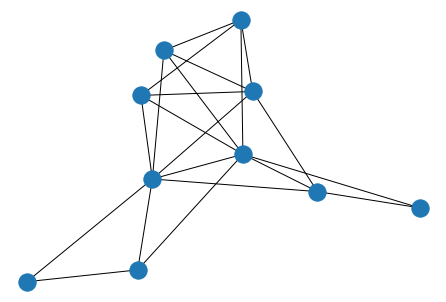

In [33]:
#@title Plot the first graph
plot_graph(0)

this graph has 67 of Substructure.TAILED_TRIANGLE_GRAPH


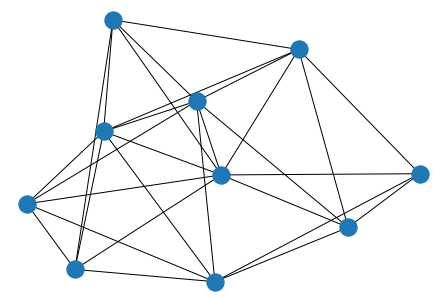

In [34]:
#@title Plot the last graph
plot_graph(999)

In [35]:
#@title Plot label distribution
import seaborn as sns
sns.displot(sampler_out['data']['substruct_counts'])

ModuleNotFoundError: No module named 'seaborn'